# Library Import and Functions

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud


## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
name: relative_transcript_abundance

purpose: calculate relative transcript abundance

input: a dataframe with a ref_gene_id column identifying the transcript gene of origin and a cov columns with 
the coverage for the transcripts.

output: the same dataframe with a relative abundance column added
'''



def relative_transcript_abundance(df):
    
    first=True
    
    for col in df.filter(regex='[0-9]_count').columns:
        
        col_gene_name = col.split("_coun")[0] + "_total_gene_counts"
        col_relative_abundance = col.split("_count")[0] + "_relative_abundance"
    
        df_sums = df[["gene_id", col]].groupby("gene_id").sum()

        df_sums[col_gene_name] = df_sums[col].copy()

        df_sums.drop(columns=col, inplace=True)

        if first:
            merged_df = pd.merge(df, df_sums, how='inner', on="gene_id")
            merged_df[col_relative_abundance] = ((merged_df[col]/merged_df[col_gene_name]) * 100)
            
        else:
            merged_df = pd.merge(merged_df, df_sums, how='inner', on="gene_id")
            merged_df[col_relative_abundance] = ((merged_df[col]/merged_df[col_gene_name]) * 100)
        
        first=False
        
    return merged_df

In [3]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = df.columns.tolist()
        list_new_names = ["gene_id"]
        
        ## gene_id comes in as index for gene counts data, make it into the first column instead
        df["gene_id"] = df.index
        cols = list(df.columns)
        cols = [cols[-1]] + cols[:-1]
        df = df[cols]
        df.reset_index(inplace=True, drop=True)
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = df.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_mapped")[0] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    df.columns = list_new_names
    
    return df 

In [4]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True, is_transcript=False, is_prot=False):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]
        
        ## Get get transcript biotype
        df["gene_biotype"] = df["other"].str.split('gene_biotype "', expand=True)[1].str.split('"', expand=True)[0]
        
        ## If is transcript get transcript id and transcript biotype
        if is_transcript:
            df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]
            df["transcript_biotype"] = df["other"].str.split('transcript_biotype "', expand=True)[1].str.split('"', expand=True)[0]
            
            ## If is prot get protein_id
            if is_prot:
                df["protein_id"] = df["other"].str.split('protein_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["ccds_id"] = df["other"].str.split('ccds_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)
        

    else:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [5]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):

    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = df.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = df.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in count_columns:
        
        df[col] = round(df[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        df[cpm_name] = round(((df[col]/(df[col].sum())) * 1000000), 2)
    
    return df  

In [6]:
## define ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

In [7]:
## Import full length counts matrix

df = pd.read_csv("../../../../data/bernardo/raw/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/fullLengthCounts_transcript.txt", sep="\t")

In [8]:
## Import and parse through extended annotations
ref = pd.read_csv("../../../../data/bernardo/raw/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])


ref = parse_df_columns(ref, is_ref=False)

In [9]:
## Get novel mitochondrial transcript ids
ref_mito_novel_ids = ref.loc[((ref["chr"] == "MT") & (ref["transcript_id"].str.startswith("Bambu")))]["transcript_id"].copy()
ref_mito_novel_ids = ref_mito_novel_ids.drop_duplicates().to_list()

In [10]:
## Create counts matrix countaining only 
df_novel_mito = df.loc[df["TXNAME"].isin(ref_mito_novel_ids)].copy()

In [11]:
## Sum counts for each novel mito transcripts
df_novel_mito["total_counts"] = df_novel_mito[df_novel_mito.columns[2:]].sum(axis=1)

In [12]:
## Set parameters for figures
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 12,8
rcParams.update({'font.size': 12})
rcParams['axes.linewidth'] = 3


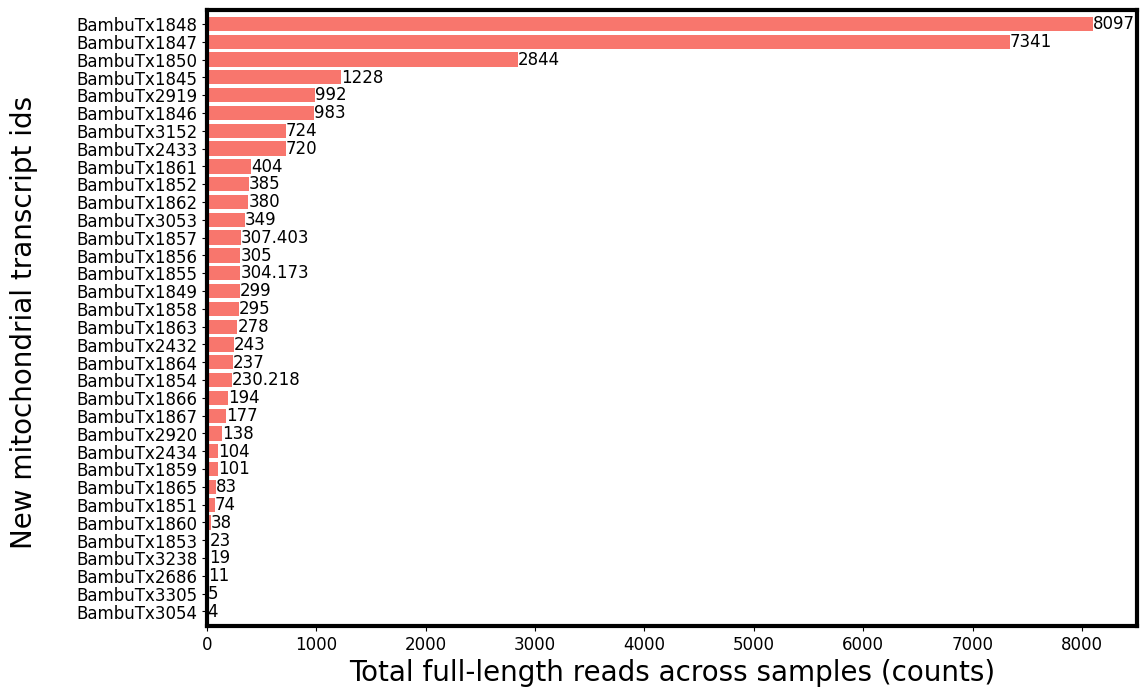

In [13]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

ax = sns.barplot(data=df_novel_mito, x="total_counts", y="TXNAME",
            color=ggplot2_colors[0], saturation=1, 
                 order=df_novel_mito.sort_values(by="total_counts", ascending=False)["TXNAME"])

ax.bar_label(ax.containers[0])

#ax.bar_label(ax.containers[0])
plt.ylabel("New mitochondrial transcript ids \n", fontsize=20)
plt.xlabel("Total full-length reads across samples (counts)", fontsize=20)
ax.set_ylim(33.8, -0.8)

plt.savefig('../../../../figures/bernardo/01.exploratory_analysis/mito/novel_transcripts_full_counts.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../../figures/bernardo/01.exploratory_analysis/mito/novel_transcripts_full_counts.svg', dpi=300, transparent=True, bbox_inches="tight")

In [15]:
## Display results
df_novel_mito["total_counts"].mean()

821.0821809698617

In [16]:
## Repeat process for known mito transcripts

## Get novel mitochondrial transcript ids
ref_mito_known_ids = ref.loc[((ref["chr"] == "MT") & (ref["transcript_id"].str.startswith("E")))]["transcript_id"].copy()
ref_mito_known_ids = ref_mito_known_ids.drop_duplicates().to_list()


## Create counts matrix countaining only 
df_known_mito = df.loc[df["TXNAME"].isin(ref_mito_known_ids)].copy()


## Sum counts for each novel mito transcripts
df_known_mito["total_counts"] = df_known_mito[df_known_mito.columns[2:]].sum(axis=1)

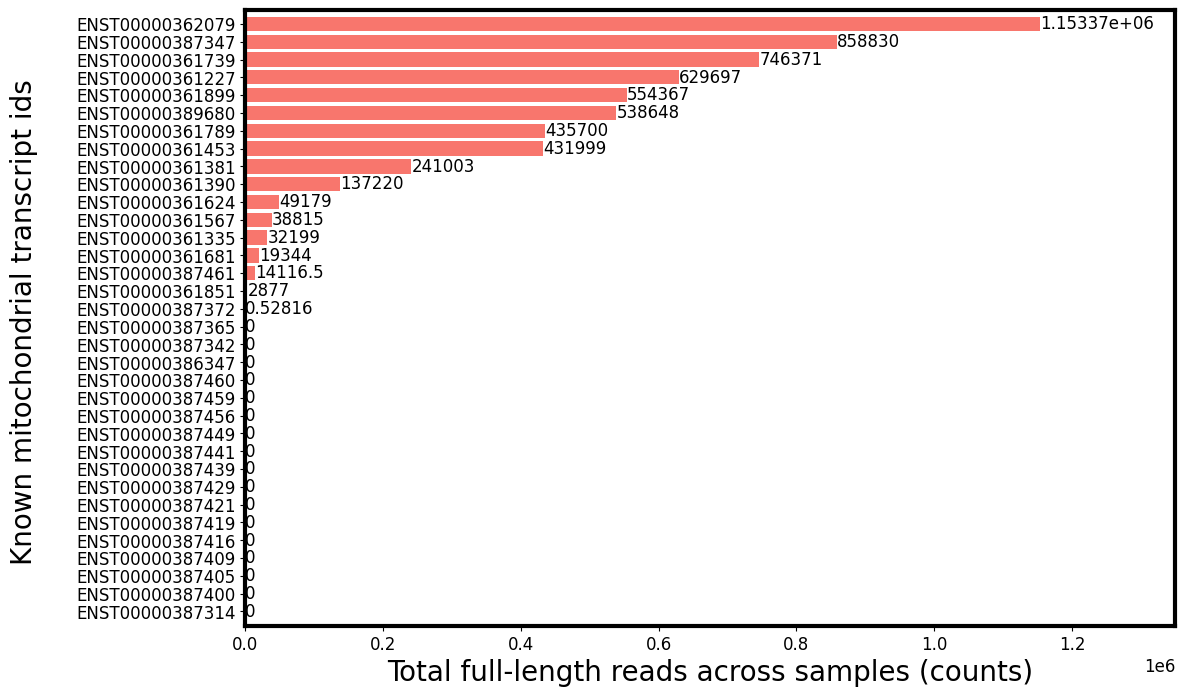

In [17]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

ax = sns.barplot(data=df_known_mito, x="total_counts", y="TXNAME",
            color=ggplot2_colors[0], saturation=1, 
                 order=df_known_mito.sort_values(by="total_counts", ascending=False)["TXNAME"])

ax.bar_label(ax.containers[0])
plt.ylabel("Known mitochondrial transcript ids \n", fontsize=20)
plt.xlabel("Total full-length reads across samples (counts)", fontsize=20)
ax.set_ylim(33.8, -0.8)
ax.set_xlim(0, 1350000)

plt.savefig('../../../../figures/bernardo/01.exploratory_analysis/mito/known_transcripts_full_counts.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../../figures/bernardo/01.exploratory_analysis/mito/known_transcripts_full_counts.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [17]:
## Display results
df_known_mito["total_counts"].mean()

159019.8471946569

In [18]:
ref_mito_novel = ref.loc[((ref["chr"] == "MT") & (ref["transcript_id"].str.startswith("Bambu")))].copy()

In [19]:
## Only keep exon entries and add size variable
ref_exons_mito_novel = ref_mito_novel.loc[ref_mito_novel["type"] == "exon"].copy()
ref_exons_mito_novel["size"] = abs(ref_exons_mito_novel["end"] - ref_exons_mito_novel["start"])

In [20]:
## get number of exons for each threshold
ref_exons_mito_novel_num_exons = ref_exons_mito_novel["transcript_id"].value_counts()

In [21]:
## Set parameters for figures
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 12,8
rcParams.update({'font.size': 18})
rcParams['axes.linewidth'] = 3

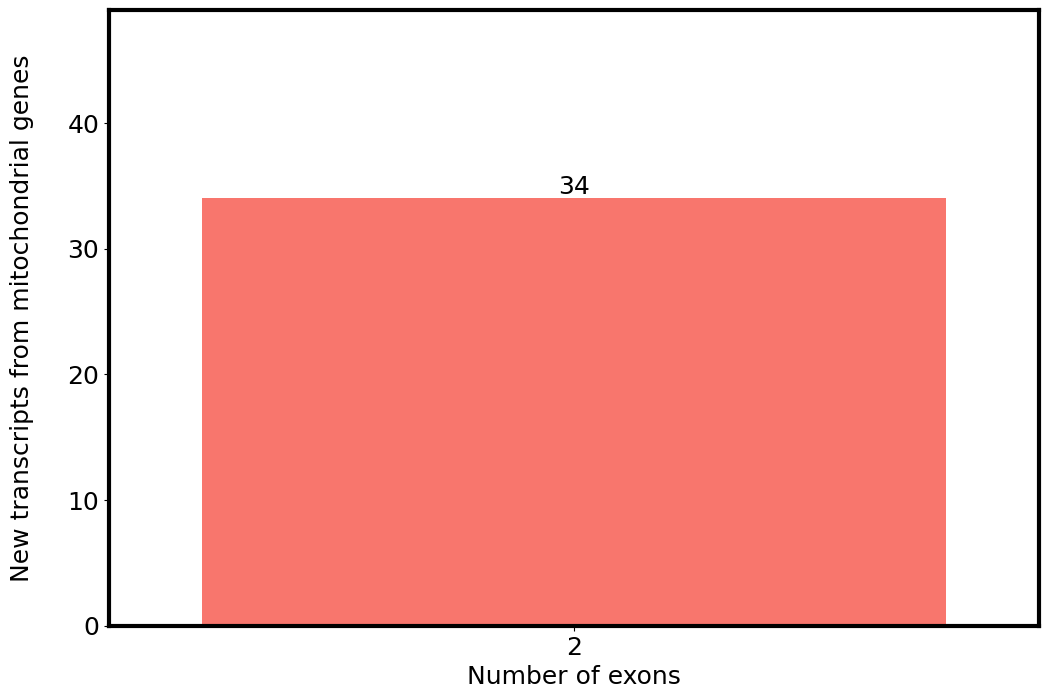

In [22]:
## Make average CPM > 1 gene body number of exons plot and save both as png and svg.

ax = sns.countplot(x=ref_exons_mito_novel_num_exons, color=ggplot2_colors[0], saturation=1)
    
for container in ax.containers:
    ax.bar_label(container)

ax.set_ylim(0, 49)

plt.xlabel("Number of exons")
plt.ylabel("New transcripts from mitochondrial genes\n")

plt.savefig('../../../../figures/bernardo/01.exploratory_analysis/mito/num_exons_novel_mito.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../../figures/bernardo/01.exploratory_analysis/mito/num_exons_novel_mito.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [23]:
# figure size in inches
rcParams['figure.figsize'] = 12,8
rcParams.update({'font.size': 18})
rcParams['axes.linewidth'] = 3

In [24]:
## Create dataframes with exonic length for each transcript
df_exonic_length_novel_mito = ref_exons_mito_novel[["transcript_id", "size"]].groupby('transcript_id').sum()

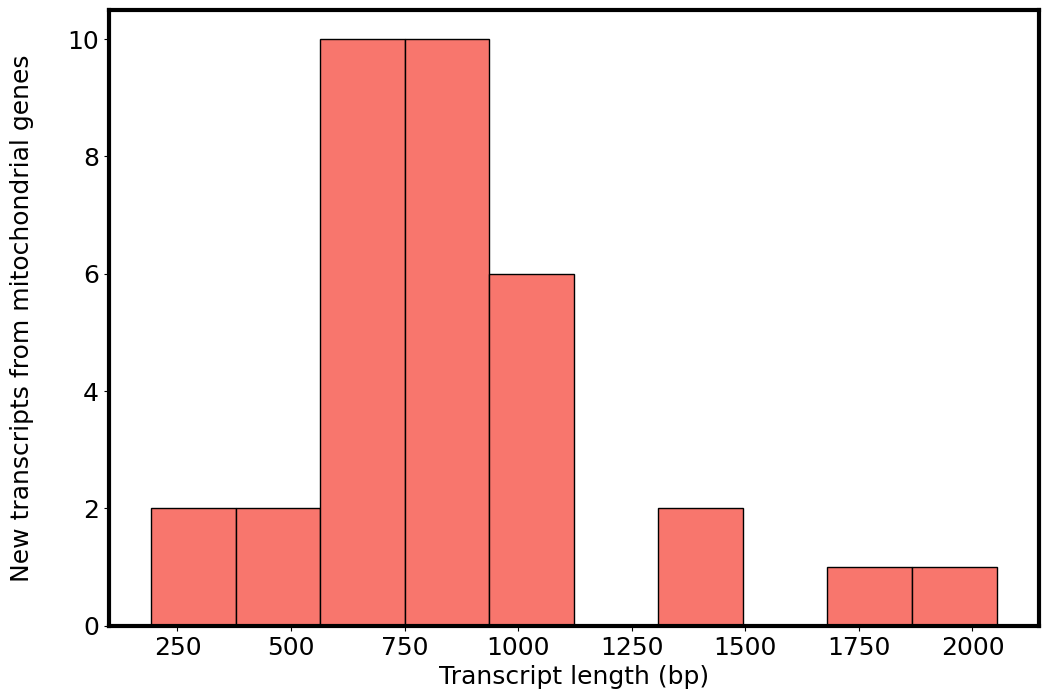

In [25]:
## Make average CPM > 1 gene body number of exons plot and save both as png and svg.

sns.histplot(x=df_exonic_length_novel_mito["size"], color=ggplot2_colors[0], alpha=1)
plt.xlabel("Transcript length (bp)")
plt.ylabel("New transcripts from mitochondrial genes\n")

plt.savefig('../../../../figures/bernardo/01.exploratory_analysis/mito/exonic_length_novel_mito_transcripts.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../../figures/bernardo/01.exploratory_analysis/mito/exonic_length_novel_mito_transcripts.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [26]:
ref_mito_known = ref.loc[((ref["chr"] == "MT") & (ref["transcript_id"].str.startswith("ENST")))].copy()

In [27]:
## Only keep exon entries and add size variable
ref_exons_mito_known = ref_mito_known.loc[ref_mito_known["type"] == "exon"].copy()
ref_exons_mito_known["size"] = abs(ref_mito_known["end"] - ref_mito_known["start"])

In [28]:
## get number of exons for each threshold
ref_exons_mito_known_num_exons = ref_exons_mito_known["transcript_id"].value_counts()

In [29]:
## Set parameters for figures
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 12,8
rcParams.update({'font.size': 18})
rcParams['axes.linewidth'] = 3

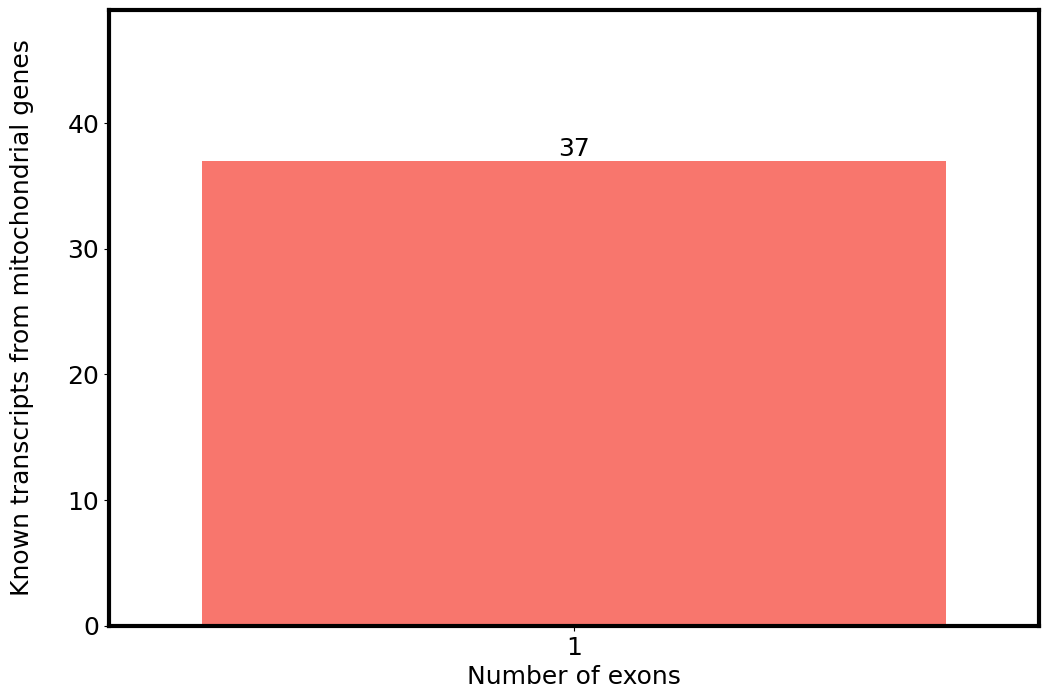

In [30]:
## Make average CPM > 1 gene body number of exons plot and save both as png and svg.

ax = sns.countplot(x=ref_exons_mito_known_num_exons, color=ggplot2_colors[0], saturation=1)
    
for container in ax.containers:
    ax.bar_label(container)

ax.set_ylim(0, 49)

plt.xlabel("Number of exons")
plt.ylabel("Known transcripts from mitochondrial genes\n")

plt.savefig('../../../../figures/bernardo/01.exploratory_analysis/mito/num_exons_known_mito.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../../figures/bernardo/01.exploratory_analysis/mito/num_exons_known_mito.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [31]:
# figure size in inches
rcParams['figure.figsize'] = 12,8
rcParams.update({'font.size': 18})
rcParams['axes.linewidth'] = 3

In [32]:
## Create dataframes with exonic length for each transcript
df_exonic_length_known_mito = ref_exons_mito_known[["transcript_id", "size"]].groupby('transcript_id').sum()

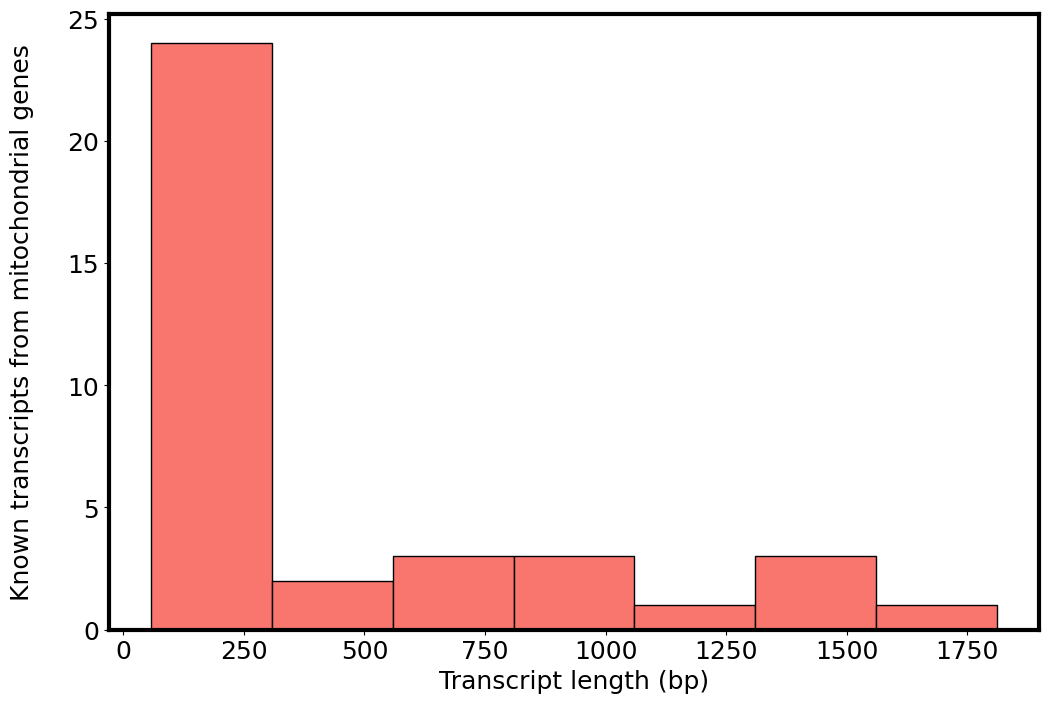

In [33]:
## Make average CPM > 1 gene body number of exons plot and save both as png and svg.

sns.histplot(x=df_exonic_length_known_mito["size"], color=ggplot2_colors[0], alpha=1)
plt.xlabel("Transcript length (bp)")
plt.ylabel("Known transcripts from mitochondrial genes\n")

plt.savefig('../../../../figures/bernardo/01.exploratory_analysis/mito/exonic_length_known_mito_transcripts.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../../figures/bernardo/01.exploratory_analysis/mito/exonic_length_known_mito_transcripts.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [120]:
## Import full length counts matrix

df = pd.read_csv("../../../../data/bernardo/raw/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/fullLengthCounts_transcript.txt", sep="\t")

In [121]:
## Fix columns names
df = fix_column_names(df, is_gene=False)

In [122]:
## Sum counts for each novel mito transcripts
df["total_counts"] = df[df.columns[2:]].sum(axis=1)

In [123]:
## Create filtered dataframes
df_mt = df.loc[((df["transcript_id"].isin(ref_mito_known_ids)) | (df["transcript_id"].isin(ref_mito_novel_ids)))].copy()

In [124]:
## Calculate relative abundance of full-length reads for SMN1 and SMN2

df_mito_relative_abundance = relative_transcript_abundance(df_mt)

In [125]:
## Fill NAs with 0s
df_mito_relative_abundance.fillna(0, inplace=True)

In [126]:
## Calculate TOTAL GENE COUNTS FOR ALL SAMPLES
df_mito_relative_abundance["TOTAL_COUNTS"] = df_mito_relative_abundance[df_mito_relative_abundance.filter(regex="[0=9]_counts").columns].sum(axis=1)

In [127]:
## Take out transcripts with 0 total counts across all samples
df_mito_relative_abundance = df_mito_relative_abundance.loc[df_mito_relative_abundance["TOTAL_COUNTS"] > 0].copy()

df_mito_relative_abundance.drop(columns="TOTAL_COUNTS", inplace=True)

In [128]:
## Create melted dataframes

df_mito_relative_abundance_melt = pd.melt(df_mito_relative_abundance, id_vars=['gene_id', 'transcript_id'],
                                          value_vars=df_mito_relative_abundance.filter(regex="relative").columns,
                                          value_name="relative_abundance_percent")

df_mito_counts_melt = pd.melt(df_mito_relative_abundance, id_vars=['gene_id', 'transcript_id'],
                                          value_vars=df_mito_relative_abundance.filter(regex="[0-9]_count").columns,
                                          value_name="count")

In [138]:
## Set parameters for figures
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 12,16
rcParams.update({'font.size': 12})
rcParams['axes.linewidth'] = 3


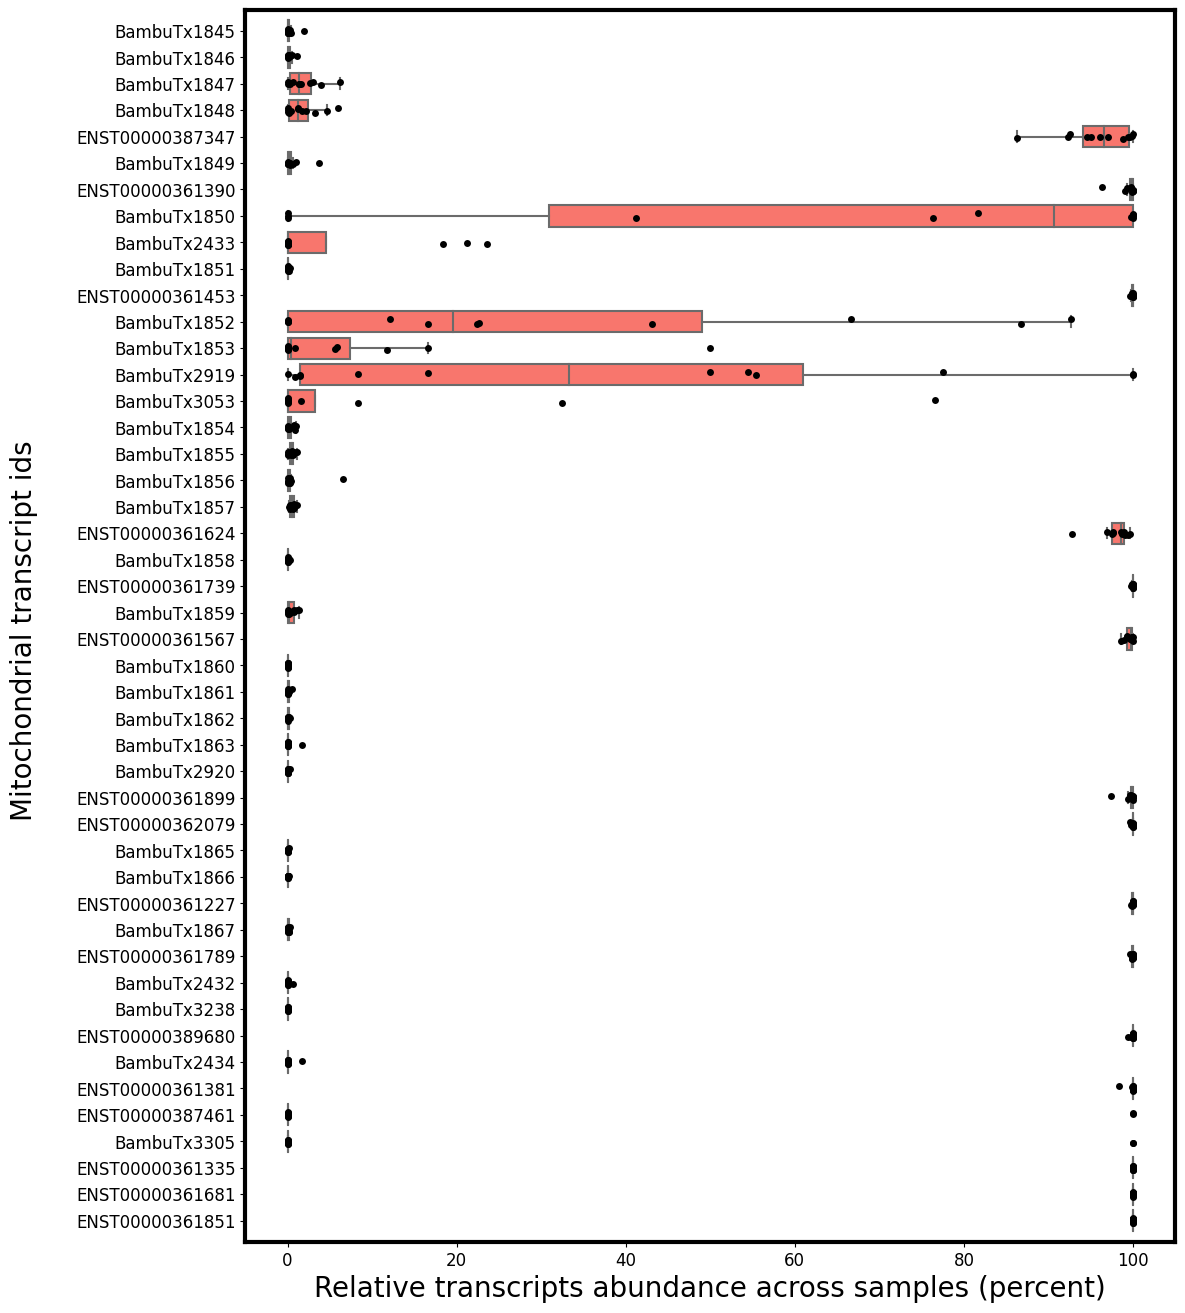

In [146]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

ax = sns.boxplot(data=df_mito_relative_abundance_melt, x="relative_abundance_percent", y="transcript_id",
            color=ggplot2_colors[0], saturation=1, showfliers=False)

sns.stripplot(data=df_mito_relative_abundance_melt,  y="transcript_id", x="relative_abundance_percent",
             color="black")

plt.ylabel("Mitochondrial transcript ids \n", fontsize=20)
plt.xlabel("Relative transcripts abundance across samples (percent)", fontsize=20)
ax.set_ylim(45.8, -0.8)

plt.savefig('../../../../figures/bernardo/01.exploratory_analysis/mito/mito_transcripts_percent_abundance_full_length.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../../figures/bernardo/01.exploratory_analysis/mito/mito_transcripts_percent_abundance_full_length.svg', dpi=300, transparent=True, bbox_inches="tight")

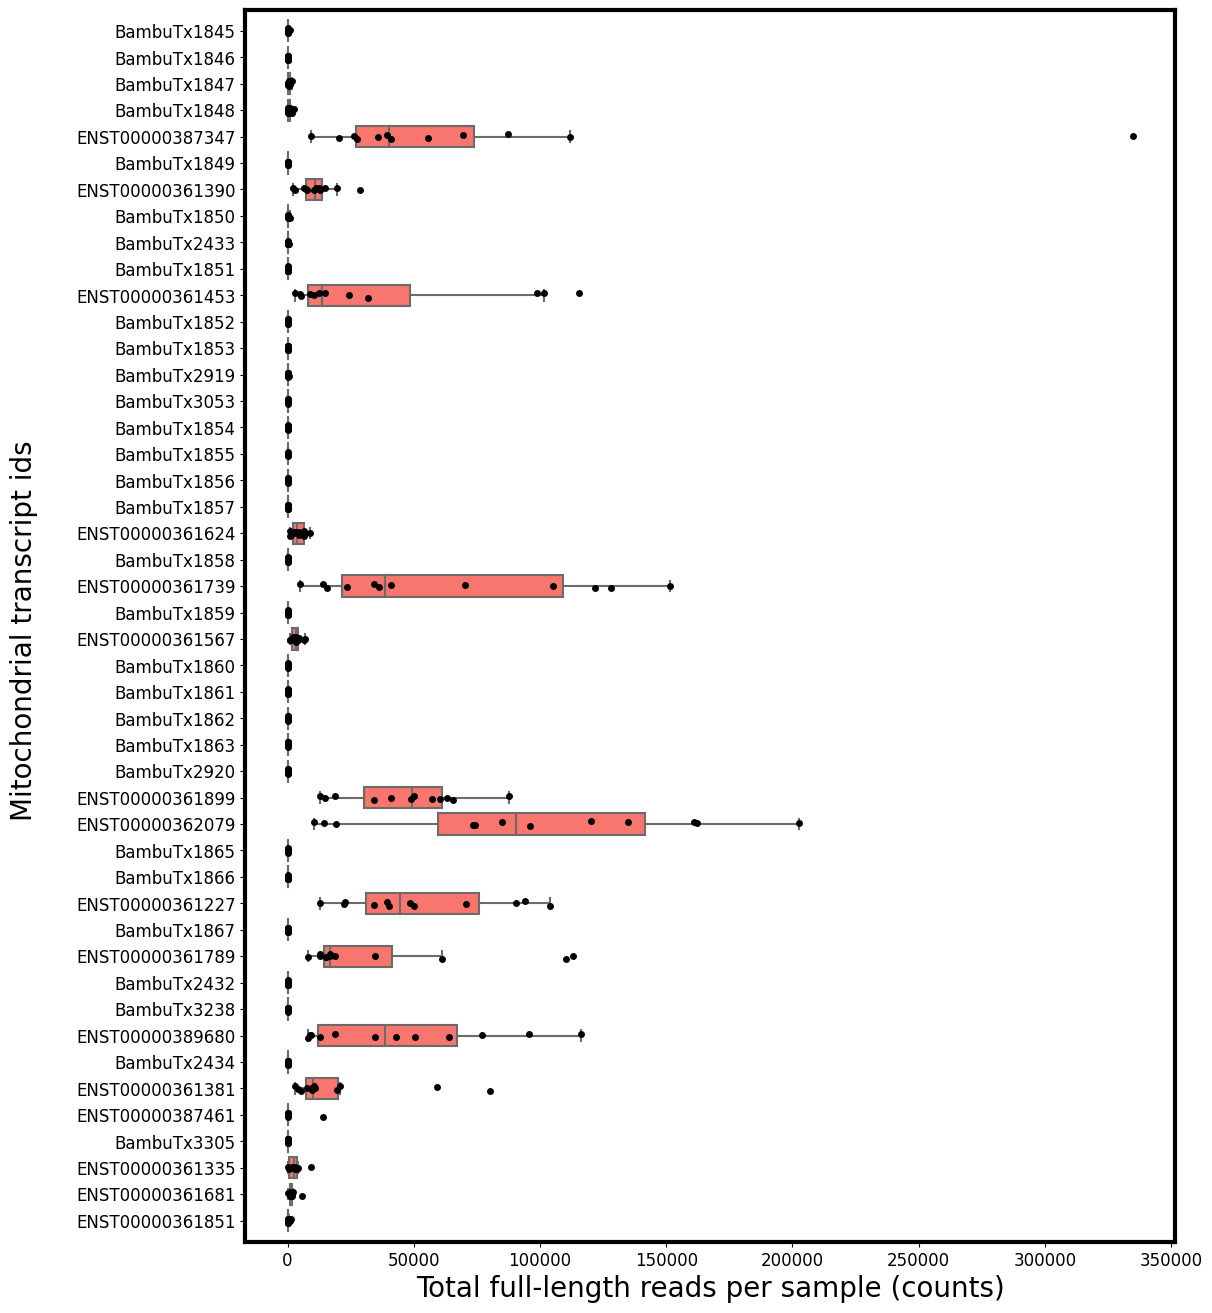

In [149]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

ax = sns.boxplot(data=df_mito_counts_melt, x="count", y="transcript_id",
            color=ggplot2_colors[0], saturation=1, showfliers=False)

sns.stripplot(data=df_mito_counts_melt,  y="transcript_id", x="count",
             color="black")

plt.ylabel("Mitochondrial transcript ids \n", fontsize=20)
plt.xlabel("Total full-length reads per sample (counts)", fontsize=20)
ax.set_ylim(45.8, -0.8)

plt.savefig('../../../../figures/bernardo/01.exploratory_analysis/mito/mito_transcripts_full_counts_per_sample.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../../figures/bernardo/01.exploratory_analysis/mito/mito_transcripts_full_counts_per_sample.svg', dpi=300, transparent=True, bbox_inches="tight")